# Проект: Персонализация предложений постоянным клиентам интернет-магазина «В один клик»

## Описание проекта

### Цели проекта
- Построить модель, прогнозирующую вероятность **снижения покупательской активности** в ближайшие 3 месяца.  
- Сегментировать клиентов с учётом **вероятности оттока** и **прибыльности** для компании.  
- Сформировать **рекомендации по персонализированным маркетинговым действиям**, способным удержать и активизировать ключевые сегменты.

---

### Данные
| Файл | Содержание | Ключевые столбцы |
|------|------------|------------------|
| `market_file.csv` | Коммуникации, продуктовое поведение, поведение на сайте | `id`, `Покупательская активность`, прочие признаки |
| `market_money.csv` | Выручка по периодам (`текущий`, `предыдущий`, `предпредыдущий` месяцы) | `id`, `Период`, `Выручка` |
| `market_time.csv` | Время на сайте по тем же периодам | `id`, `Период`, `минут` |
| `money.csv` | Среднемесячная прибыль за последние 3 месяца | `id`, `Прибыль` |

- **Идентификатор** клиента во всех таблицах — `id`.  
- **Целевой признак**: `Покупательская активность` («снизилась» / «прежний уровень»).

---

### Основные этапы работы
1. **Загрузка данных**  
   Проверка типов, размеров и уникальности `id`.
2. **Предобработка**  
   - Обработка пропусков и дубликатов.  
   - Приведение числовых и категориальных типов.  
3. **Исследовательский анализ**  
   - Статистика распределений, графики.  
   - Отбор клиентов с активностью ≥ 3 месяцев.  
4. **Объединение таблиц**  
   - Поворот `market_money` и `market_time` в широкие форматы по периодам.  
   - Слияние всех признаков в единый датасет для моделирования.  
5. **Корреляционный анализ**  
   - Выявление и устранение мультиколлинеарности.  
6. **Построение моделей**  
   - Пайплайны с `ColumnTransformer`, двумя кодировщиками и двумя скейлерами.  
   - Обучение KNN, DecisionTree, LogisticRegression, SVC; подбор гиперпараметров.  
   - Выбор лучшей модели по ROC-AUC (или иной обоснованной метрике).  
7. **Интерпретация важности признаков** (SHAP)  
   - Определение значимых и незначимых факторов.  
8. **Сегментация покупателей**  
   - Комбинация вероятности оттока и прибыльности.  
   - Аналитика выбранного сегмента и предложения по его активации.  
9. **Финальный отчёт**  
   - Итоги работы, рекомендации для бизнеса, достижения модели.

---

### Ожидаемые результаты
- Чистый, единый датасет, готовый к обучению моделей.  
- Лучшая модель с **целевым ROC-AUC ≥ 0.75** (ориентир).  
- Визуализация важности признаков и выводы о ключевых драйверах снижения активности.  
- Чёткие клиентские сегменты с конкретными предложениями по увеличению покупательской активности.  
- Полный Jupyter Notebook с кодом, графиками и пояснениями, готовый к демонстрации руководству.

---


## Загрузка библиотек и данных

### Библиотеки

In [1]:
pip install shap==0.41.0 -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install scikit-learn==1.1.3 -q

In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np

In [6]:
import seaborn as sns

In [7]:
from sklearn.pipeline import Pipeline

In [8]:
from sklearn.compose import ColumnTransformer

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder

In [10]:
from sklearn.impute import SimpleImputer

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
from sklearn.svm import SVC

In [17]:
from sklearn.metrics import roc_auc_score

In [18]:
import shap

### Датасеты

#### `market_file`
**Данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении**

In [19]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_file.info()
market_file.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [20]:
market_file['Покупательская активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

#### `market_money`
**Данные о выручке, которую получает магазин с покупателя**

In [21]:
market_money = pd.read_csv('/datasets/market_money.csv')
market_money.info()
market_money.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


#### `market_time`
**Данные о времени, которое покупатель провёл на сайте в течение периода**

In [22]:
market_time = pd.read_csv('/datasets/market_time.csv')
market_time.info()
market_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


#### `money`
**Данные о среднемесячной прибыли**

In [23]:
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
money.info()
money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


## Предобработка данных

### Предобработка `market_file`

In [24]:
# Проверка пропусков
print("Пропуски по столбцам в market_file:")
nulls = market_file.isnull().sum()
if nulls.sum() > 0:
    print(nulls[nulls > 0])
else:
    print("✅ Нет пропусков")

Пропуски по столбцам в market_file:
✅ Нет пропусков


In [25]:
# Проверка явных дубликатов (по всем столбцам)
dup_count = market_file.duplicated().sum()
print(f"Явных дубликатов строк: {dup_count}")
if dup_count > 0:
    market_file = market_file.drop_duplicates()
    print(f"Удалено {dup_count} дубликатов")
else:
    print("✅ Явных дубликатов нет")

Явных дубликатов строк: 0
✅ Явных дубликатов нет


In [26]:
# Проверка неявных дубликатов в строковых колонках
# Поиск строковых колонок
obj_cols = market_file.select_dtypes(include='object').columns

# Вывод уникальных значений для анализа
print("\n🔍 Уникальные значения в строковых колонках:")
for col in obj_cols:
    print(f"\nСтолбец: {col}")
    print(market_file[col].unique())


🔍 Уникальные значения в строковых колонках:

Столбец: Покупательская активность
['Снизилась' 'Прежний уровень']

Столбец: Тип сервиса
['премиум' 'стандартт' 'стандарт']

Столбец: Разрешить сообщать
['да' 'нет']

Столбец: Популярная_категория
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [27]:
# Замена неявных дубликатов в строковых колонках
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace({'стандартт': 'стандарт'})

### Предобработка `market_money`

In [28]:
# Проверка пропусков
print("Пропуски по столбцам в market_money:")
nulls = market_money.isnull().sum()
if nulls.sum() > 0:
    print(nulls[nulls > 0])
else:
    print("✅ Нет пропусков")

Пропуски по столбцам в market_money:
✅ Нет пропусков


In [29]:
# Проверка явных дубликатов (по всем столбцам)
dup_count1 = market_money.duplicated().sum()
print(f"Явных дубликатов строк: {dup_count}")
if dup_count > 0:
    market_money = market_money.drop_duplicates()
    print(f"Удалено {dup_count} дубликатов")
else:
    print("✅ Явных дубликатов нет")

Явных дубликатов строк: 0
✅ Явных дубликатов нет


In [30]:
# Проверка неявных дубликатов в строковых колонках
# Поиск строковых колонок
obj_cols = market_money.select_dtypes(include='object').columns

# Вывод уникальных значений для анализа
print("\n🔍 Уникальные значения в строковых колонках:")
for col in obj_cols:
    print(f"\nСтолбец: {col}")
    print(market_money[col].unique())


🔍 Уникальные значения в строковых колонках:

Столбец: Период
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


### Предобработка `market_time`

In [31]:
# Проверка пропусков
print("Пропуски по столбцам в market_time:")
nulls = market_time.isnull().sum()
if nulls.sum() > 0:
    print(nulls[nulls > 0])
else:
    print("✅ Нет пропусков")

Пропуски по столбцам в market_time:
✅ Нет пропусков


In [32]:
# Проверка явных дубликатов (по всем столбцам)
dup_count = market_time.duplicated().sum()
print(f"Явных дубликатов строк: {dup_count}")
if dup_count > 0:
    market_time = market_time.drop_duplicates()
    print(f"Удалено {dup_count} дубликатов")
else:
    print("✅ Явных дубликатов нет")

Явных дубликатов строк: 0
✅ Явных дубликатов нет


In [33]:
# Проверка неявных дубликатов в строковых колонках
# Поиск строковых колонок
obj_cols = market_time.select_dtypes(include='object').columns

# Вывод уникальных значений для анализа
print("\n🔍 Уникальные значения в строковых колонках:")
for col in obj_cols:
    print(f"\nСтолбец: {col}")
    print(market_time[col].unique())


🔍 Уникальные значения в строковых колонках:

Столбец: Период
['текущий_месяц' 'предыдцщий_месяц']


In [34]:
# Замена орфагрофической ошибки в столбце 'Период'
market_time['Период'] = market_time['Период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})

### Предобработка `money`

In [35]:
# Проверка пропусков
print("Пропуски по столбцам в money:")
nulls = money.isnull().sum()
if nulls.sum() > 0:
    print(nulls[nulls > 0])
else:
    print("✅ Нет пропусков")

Пропуски по столбцам в money:
✅ Нет пропусков


In [36]:
# Проверка явных дубликатов (по всем столбцам)
dup_count = money.duplicated().sum()
print(f"Явных дубликатов строк: {dup_count}")
if dup_count > 0:
    money = money.drop_duplicates()
    print(f"Удалено {dup_count} дубликатов")
else:
    print("✅ Явных дубликатов нет")

Явных дубликатов строк: 0
✅ Явных дубликатов нет


**Приведение данных по прибыли к масштабу выручки**

Так как значения в столбце `Прибыль` в датасете `money` представлены в условных единицах (в десятках или сотнях), а данные в `market_money` — в тысячах, необходимо привести их к единому масштабу. Для этого умножаем столбец `Прибыль` на 1000, чтобы значения прибыли были сопоставимы с масштабом выручки из других таблиц.

In [37]:
# Приведение прибыли к масштабу выручки
money['Прибыль'] = money['Прибыль'] * 1000

## Исследовательский анализ данных

### Анализ `market_file`

#### Построение гистограмм для числовых столбцов

In [38]:
market_file.head(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


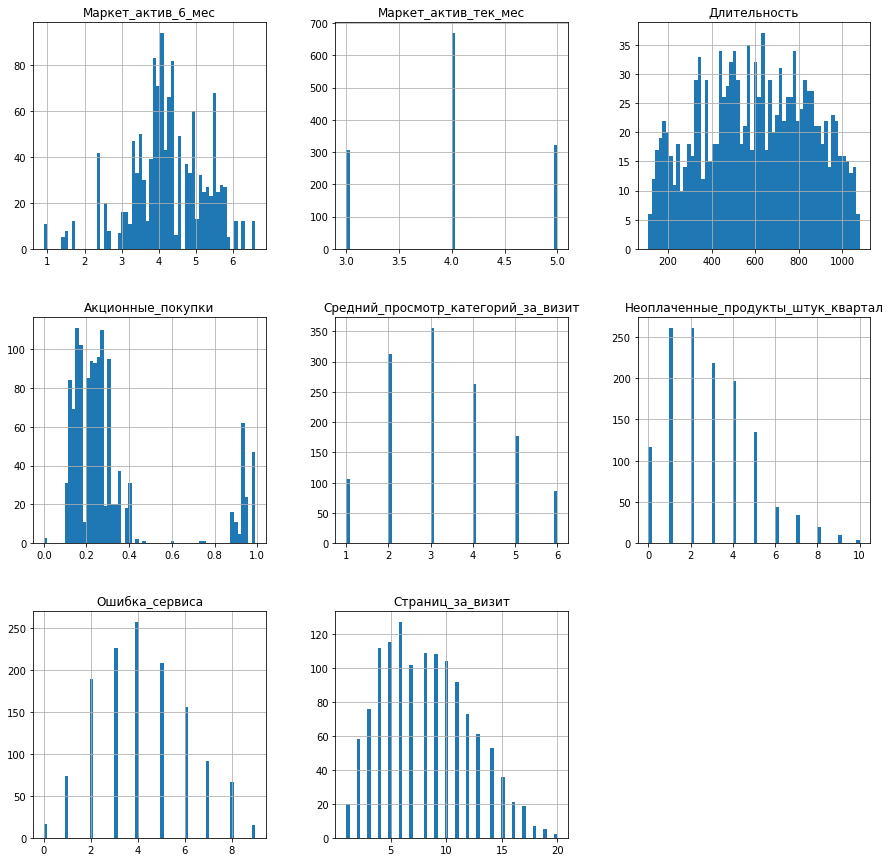

In [39]:
market_file.drop('id', axis=1).hist(bins=60, figsize=(15,15));

Вывод по количественным признакам таблицы `market_file` 

---
🔹 `Маркет_актив_тек_мес`
- Признак имеет дискретное распределение, значения сосредоточены в диапазоне **3–5**.
- Выбросов и аномалий не выявлено, признак оставляем без изменений.
---
🔹 `Средний_просмотр_категорий_за_визит`
- Дискретный признак, значения в основном от **1 до 5**, максимум **6**.
- Распределение нормальное для категориального признака, выбросов нет.
- Возможна бинаризация для упрощения модели: "Больше 3 категорий за визит — да/нет".
---
🔹 `Неоплаченные_продукты_штук_квартал`
- Большинство значений сосредоточено в диапазоне **0–3**, наблюдается плавное убывание к максимуму **10**.
- Аномалий и пропусков нет, признак оставляем без изменений.
---
🔹 `Ошибка_сервиса`
- Распределение с пиком на **4 ошибки**, максимум — **9**.
- Выбросов не выявлено, признак оставляем для дальнейшего анализа.
---
🔹 `Страниц_за_визит`
- Распределение близко к нормальному, с центром на **10–15 страниц**, хвосты до **20**.
- Признак адекватный, дополнительных преобразований не требует.
---

**Общий вывод:**  
Все рассмотренные признаки имеют корректное распределение, выбросов и аномалий не обнаружено. Признаки оставляем в модель для дальнейшего анализа.  
Подробный разбор признаков `Маркет_актив_6_мес`, `Длительность` и `Акционные_покупки` будет представлен ниже.

#### `Маркет_актив_6_мес`

In [40]:
market_file['Маркет_актив_6_мес'].describe()

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64

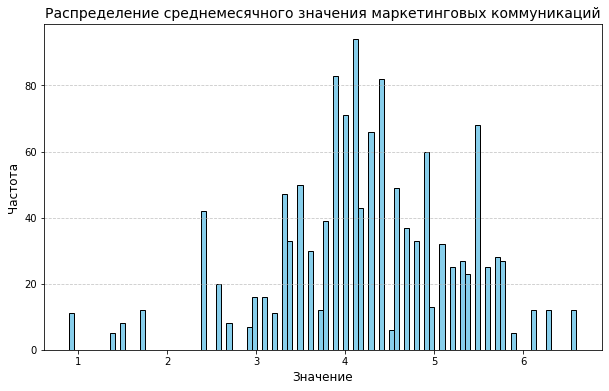

In [41]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.hist(market_file['Маркет_актив_6_мес'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение среднемесячного значения маркетинговых коммуникаций', fontsize=14)
plt.xlabel('Значение', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

**Вывод по признаку `Маркет_актив_6_мес`**

- **Распределение** имеет положительную асимметрию: основная масса клиентов сосредоточена в диапазоне **2.5–5**, отдельные выбросы достигают **6**.
- **Статистика**:
  - Среднее значение: **4.25**
  - Медиана: **4.2** (50-й перцентиль)
  - 75% клиентов имеют значение ≤ **4.7**
- **Выбросы**:
  - Клиентов с большими значениями (>5) немного, их удаление не требуется, так как они находятся в допустимом диапазоне.
- **Рекомендация**:
  - Признак информативный, оставляем без изменений.
  - Возможно, рассмотреть добавление новых признаков: например, "высокая маркетинговая активность" (значения >5) как бинарный индикатор.



#### `Длительность`

In [42]:
market_file['Длительность'].describe()

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64

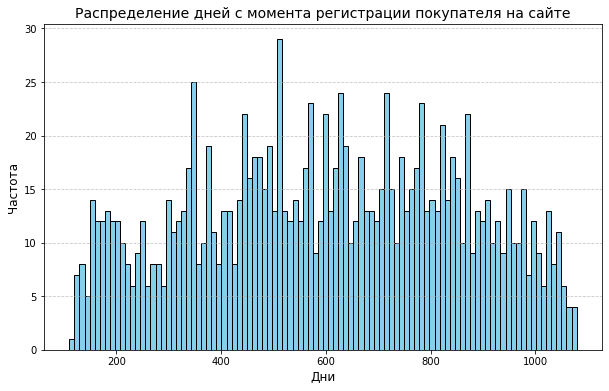

In [43]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.hist(market_file['Длительность'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение дней с момента регистрации покупателя на сайте', fontsize=14)
plt.xlabel('Дни', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

Вывод по признаку `Длительность`

- **Распределение** довольно равномерное, с лёгким смещением вправо. Большинство значений находятся в диапазоне **~200–1000 дней**.
- **Статистика**:
  - Среднее значение: **~602 дня**.
  - Медиана: **606 дней**.
  - 25-й перцентиль: **405 дней**, 75-й перцентиль: **806 дней**.
  - Минимум: **110 дней**, максимум: **1079 дней**.
- **Выбросы**:
  - Явных выбросов нет, минимальное значение **110 дней** выглядит логичным, так как речь о длительности взаимодействия с магазином.
- **Вывод**:
  - Признак полезный, хорошо распределён, удаление значений не требуется.  
  - Можно использовать как числовой признак для модели.

#### `Акционные_покупки`

In [44]:
market_file['Акционные_покупки'].describe()

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64

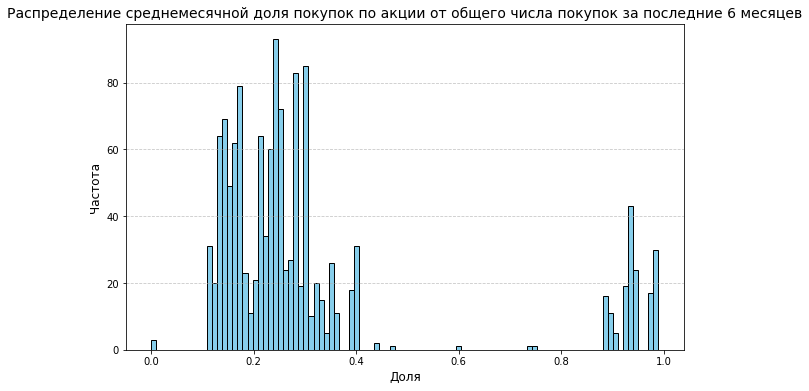

In [45]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.hist(market_file['Акционные_покупки'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение среднемесячной доля покупок по акции от общего числа покупок за последние 6 месяцев', fontsize=14)
plt.xlabel('Доля', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

Вывод по признаку `Акционные_покупки`

- **Статистика**:
  - Среднее значение: **0.32**
  - Медиана: **0.24**
  - Стандартное отклонение: **0.25**
  - Минимум: **0.0**, максимум: **1.0**
  - 25-й перцентиль: **0.17**, 75-й перцентиль: **0.30**
- **Распределение**:
  - Сильная положительная асимметрия: большинство клиентов имеют значение в диапазоне **0.0–0.4**.
  - Наблюдаются кластеры клиентов с долями покупок по акции, близкими к **1.0** — это отдельная группа клиентов ("акционные охотники").
- **Выбросы**:
  - Верхние значения (0.8–1.0) отражают поведение пользователей, которые почти все свои покупки делают по акциям. Удалять их не требуется.
- **Вывод**:
  - Признак важный, отражает стратегию покупок клиентов.
  - Рекомендуется оставить признак в модель в исходном виде.
  - Дополнительно можно создать бинарный флаг: **"Акционные_охотники"** (доля покупок по акции > 0.5).

#### `Популярная_категория`

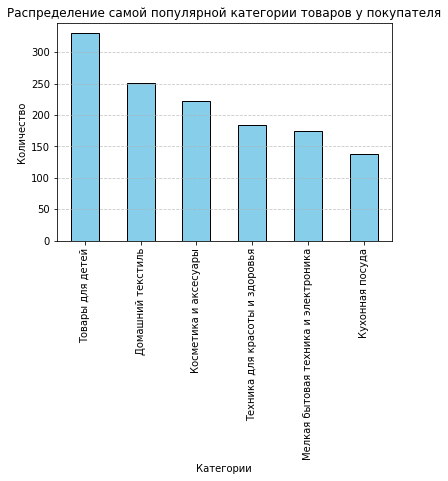

In [46]:
# Подсчет количества каждой категории
сat_counts = market_file['Популярная_категория'].value_counts()

# Построение графика
ax = сat_counts.plot(
    kind='bar',
    color='skyblue',
    edgecolor='black',
    title='Распределение самой популярной категории товаров у покупателя',
    xlabel='Категории',
    ylabel='Количество',
    )
plt.grid(axis='y', linestyle='--', alpha=0.7)

### Анализ `market_money`

Для анализа изменения выручки во времени строим гистограммы распределения суммы выручки по трём периодам:  
- **препредыдущий месяц**  
- **предыдущий месяц**  
- **текущий месяц**  

Это позволит выявить различия в паттернах покупательского поведения между периодами и проверить, есть ли изменения в распределении выручки.

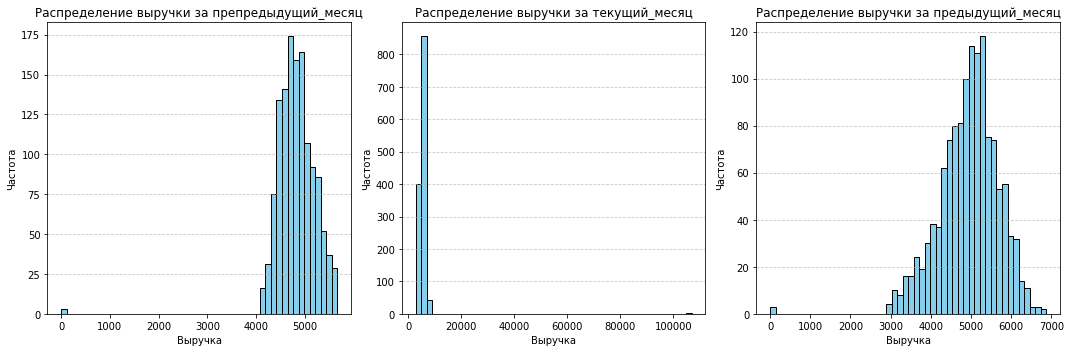

In [47]:
# Группируем по Период и строим графики
periods = market_money['Период'].unique()

plt.figure(figsize=(15, 5))

for i, period in enumerate(periods, 1):
    plt.subplot(1, 3, i)
    subset = market_money[market_money['Период'] == period]
    plt.hist(subset['Выручка'], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Распределение выручки за {period}')
    plt.xlabel('Выручка')
    plt.ylabel('Частота')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

На графиках видны явные выбросы в данных, особенно в периоде `текущий_месяц`, где встречаются значения выручки, превышающие 100 000. В других периодах (`предыдущий_месяц` и `препредыдущий_месяц`) также присутствуют аномальные значения, выбивающиеся из основной массы данных.

Для корректного анализа и дальнейшего построения модели необходимо провести очистку данных, удалив выбросы для каждого периода на основе анализа распределения выручки.

In [48]:
# Фильтрация данных
df_текущий = market_money[market_money['Период'] == 'текущий_месяц'].copy()
df_текущий = df_текущий[df_текущий['Выручка'] < 20000]

df_предыдущий = market_money[market_money['Период'] == 'предыдущий_месяц'].copy()
df_предыдущий = df_предыдущий[df_предыдущий['Выручка'] > 2000]

df_препредыдущий = market_money[market_money['Период'] == 'препредыдущий_месяц'].copy()
df_препредыдущий = df_препредыдущий[df_препредыдущий['Выручка'] > 3000]

# Объединение
market_money_cleaned = pd.concat([df_текущий, df_предыдущий, df_препредыдущий])

# Проверка
market_money_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3893 entries, 1 to 3898
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3893 non-null   int64  
 1   Период   3893 non-null   object 
 2   Выручка  3893 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.7+ KB


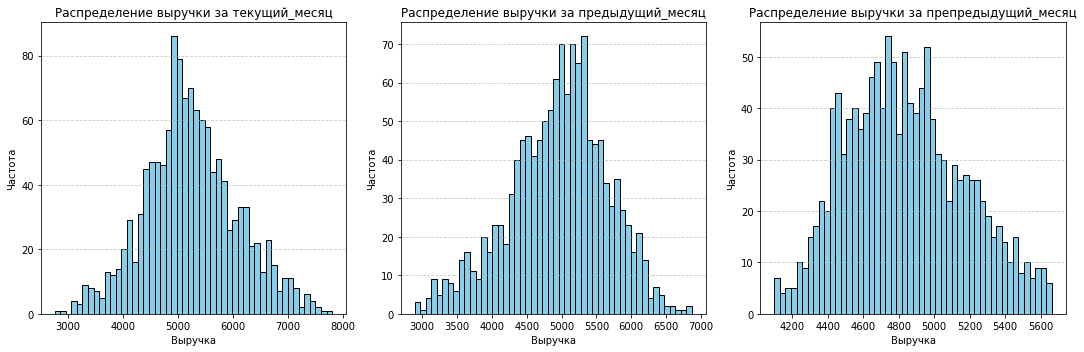

In [49]:
# Вывод отфильтрованных данных
periods = market_money_cleaned['Период'].unique()

plt.figure(figsize=(15, 5))

for i, period in enumerate(periods, 1):
    plt.subplot(1, 3, i)
    subset = market_money_cleaned[market_money_cleaned['Период'] == period]
    plt.hist(subset['Выручка'], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Распределение выручки за {period}')
    plt.xlabel('Выручка')
    plt.ylabel('Частота')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [50]:
# Вывод описательной статистики по каждому периоду для колонки "Выручка"
for period in market_money_cleaned['Период'].unique():
    print(f"\nОписательная статистика для периода: {period}")
    display(market_money_cleaned[market_money_cleaned['Период'] == period]['Выручка'].describe())


Описательная статистика для периода: текущий_месяц


count    1299.000000
mean     5236.787452
std       835.474686
min      2758.700000
25%      4705.500000
50%      5179.600000
75%      5759.950000
max      7799.400000
Name: Выручка, dtype: float64


Описательная статистика для периода: предыдущий_месяц


count    1297.000000
mean     4948.339630
std       701.228571
min      2890.000000
25%      4498.500000
50%      5005.500000
75%      5409.000000
max      6869.500000
Name: Выручка, dtype: float64


Описательная статистика для периода: препредыдущий_месяц


count    1297.000000
mean     4836.367772
std       333.438742
min      4098.000000
25%      4585.000000
50%      4812.000000
75%      5055.000000
max      5663.000000
Name: Выручка, dtype: float64

**Выводы по распределению выручки после фильтрации данных**

Данные по выручке были очищены от выбросов и аномалий, что позволило сформировать более однородные распределения по каждому периоду:

- **Текущий месяц**:  
  Среднее значение выручки составляет ~5236, медианное значение — 5179.  
  Диапазон значений — от 2785 до 7799.  
  Распределение симметричное, с основным пиком в районе 5000–5200.

- **Предыдущий месяц**:  
  Средняя выручка — ~4948, медиана — 5050.  
  Значения выручки варьируются от 2890 до 6869.  
  Распределение более суженное, основной пик также находится около 5000.

- **Препредыдущий месяц**:  
  Среднее значение — ~4836, медиана — 4812.  
  Диапазон значений от 4190 до 5605.  
  Распределение чуть более концентрировано в диапазоне 4800–5000.

**Общий вывод:**  
Данные выручки по всем трем периодам после фильтрации выглядят корректно и готовы для дальнейшего анализа и построения моделей. Распределения стаб

### Анализ `market_time`

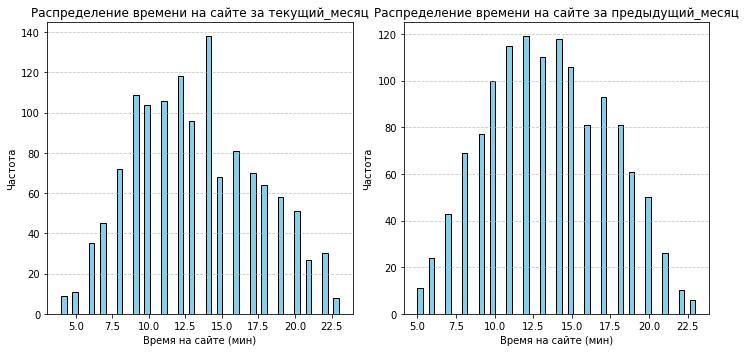

In [51]:
# Разбиваем по периодам и строим графики для market_time
periods = market_time['Период'].unique()

plt.figure(figsize=(15, 5))

for i, period in enumerate(periods, 1):
    plt.subplot(1, 3, i)
    subset = market_time[market_time['Период'] == period]
    plt.hist(subset['минут'], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Распределение времени на сайте за {period}')
    plt.xlabel('Время на сайте (мин)')
    plt.ylabel('Частота')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [52]:
# Вывод описательной статистики для каждой категории Период
for period in market_time['Период'].unique():
    print(f"\nОписательная статистика для периода: {period}")
    display(market_time[market_time['Период'] == period]['минут'].describe())


Описательная статистика для периода: текущий_месяц


count    1300.000000
mean       13.204615
std         4.220589
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64


Описательная статистика для периода: предыдущий_месяц


count    1300.000000
mean       13.467692
std         3.932029
min         5.000000
25%        11.000000
50%        13.000000
75%        17.000000
max        23.000000
Name: минут, dtype: float64

**Выводы по анализу времени, проведенного пользователями на сайте (`market_time`)**

После анализа данных по времени на сайте за разные периоды, можно сделать следующие выводы:

- **Текущий месяц**:
  - Среднее время на сайте — **13.2 минут**.
  - Медианное значение — **13 минут**.
  - Диапазон значений — от **4 до 26 минут**.
  - Распределение времени симметрично, с пиком в районе 12–14 минут.

- **Предыдущий месяц**:
  - Среднее время на сайте — **13.5 минут**.
  - Медианное значение — **13 минут**.
  - Диапазон значений — от **5 до 26 минут**.
  - Распределение времени также нормальное, основная масса значений сосредоточена в интервале 12–15 минут.

**Общий вывод:**  
Распределение времени на сайте по периодам имеет схожие характеристики: данные однородные, выбросов не выявлено. Эти данные готовы к дальнейшему анализу и построению модели.

### Анализ `money`

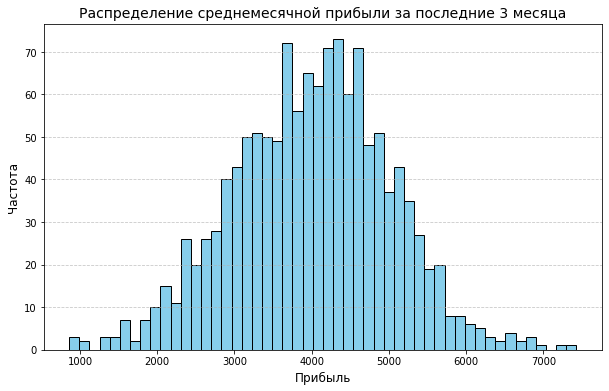

In [53]:
# Построение графика распределения среднемесячной прибыли
plt.figure(figsize=(10, 6))
plt.hist(money['Прибыль'], bins=50, color='skyblue', edgecolor='black')
plt.title('Распределение среднемесячной прибыли за последние 3 месяца', fontsize=14)
plt.xlabel('Прибыль', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [54]:
print("Описательная статистика по среднемесячной прибыли за последние 3 месяца:")
display(money['Прибыль'].describe())

Описательная статистика по среднемесячной прибыли за последние 3 месяца:


count    1300.000000
mean     3996.630769
std      1013.722112
min       860.000000
25%      3300.000000
50%      4045.000000
75%      4670.000000
max      7430.000000
Name: Прибыль, dtype: float64

Вывод по данным среднего значения прибыли за последние 3 месяца

- В среднем клиенты обеспечивают **прибыль около 4000 единиц** за месяц, что видно из среднего значения (`mean`) — **3996.63**.
- Медиана (`50%`) прибыли составляет **4045.0** единиц.
- Минимальное значение прибыли — **860 единиц**, максимальное — **7430 единиц**.
- **Стандартное отклонение (std)** — около **1013.7**, что показывает умеренную вариабельность данных.
- Наблюдаются редкие выбросы с крайне высокими значениями прибыли (например, выше **7000** единиц).

**Заключение:**  
Данные по прибыли выглядят чистыми и адекватными. Их можно использовать для дальнейшего анализа и моделирования, включая сегментацию клиентов или прогнозирование выручки.

### Отбор активных клиентов
Отбираются клиенты с покупательской активностью не менее трёх месяцев. Учитываются только клиенты, которые совершали покупки во всех трёх рассматриваемых периодах: препредыдущий, предыдущий и текущий месяц. 

In [55]:
# Подсчет количества месяцев с ненулевой выручкой для каждого клиента
active_clients = (
    market_money_cleaned.groupby('id')['Выручка']
    .apply(lambda x: (x > 0).sum())  # Подсчет количества месяцев с выручкой > 0
    .reset_index()
)

# Оставляем только клиентов с покупками в каждом из 3 месяцев
active_clients = active_clients[active_clients['Выручка'] >= 3]

# Формирование списка ID активных клиентов
active_ids = active_clients['id'].tolist()

# Примение фильтра к основным таблицам
market_money_active = market_money_cleaned[market_money_cleaned['id'].isin(active_ids)]
market_time_active = market_time[market_time['id'].isin(active_ids)]
money_active = money[money['id'].isin(active_ids)]
market_file_active = market_file[market_file['id'].isin(active_ids)]

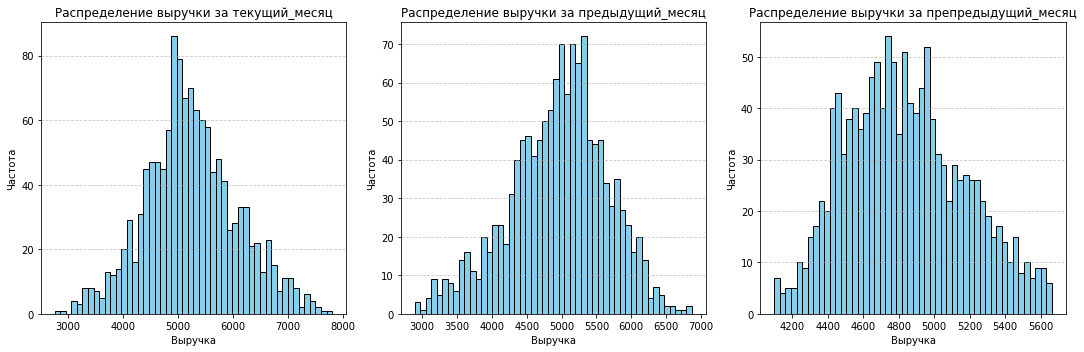

In [56]:
# Гистограммы по выручке (отфильтрованные клиенты)
periods = market_money_active['Период'].unique()

plt.figure(figsize=(15, 5))

for i, period in enumerate(periods, 1):
    plt.subplot(1, 3, i)
    subset = market_money_active[market_money_active['Период'] == period]
    plt.hist(subset['Выручка'], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Распределение выручки за {period}')
    plt.xlabel('Выручка')
    plt.ylabel('Частота')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [57]:
# Вывод описательной статистики по каждому периоду для колонки "Выручка"
for period in market_money_active['Период'].unique():
    print(f"\nОписательная статистика для периода: {period}")
    display(market_money_active[market_money_active['Период'] == period]['Выручка'].describe())


Описательная статистика для периода: текущий_месяц


count    1296.000000
mean     5238.096065
std       834.318717
min      2758.700000
25%      4706.050000
50%      5179.950000
75%      5759.275000
max      7799.400000
Name: Выручка, dtype: float64


Описательная статистика для периода: предыдущий_месяц


count    1296.000000
mean     4947.468750
std       700.797239
min      2890.000000
25%      4498.125000
50%      5005.500000
75%      5405.625000
max      6869.500000
Name: Выручка, dtype: float64


Описательная статистика для периода: препредыдущий_месяц


count    1296.000000
mean     4836.202160
std       333.514091
min      4098.000000
25%      4584.500000
50%      4810.500000
75%      5056.000000
max      5663.000000
Name: Выручка, dtype: float64

**Вывод по отбору активных клиентов**

После фильтрации клиентов с покупательской активностью не менее трёх месяцев, состав и распределения данных изменились незначительно. По сравнению с изначальным датасетом (`market_money_cleaned`), из выборки были удалены лишь несколько клиентов с неполной историей покупок.

Распределения выручки по каждому периоду остались стабильными и сохранили форму, что подтверждает отсутствие значительных искажений после фильтрации. Таким образом, дальнейший анализ можно проводить на отфильтрованной выборке, состоящей из наиболее активных клиентов, что повышает качество и релевантность результатов анализа.

## Объединение таблиц

Перед началом моделирования необходимо объединить данные из таблиц `market_file`, `market_money_active` и `market_time_active`.  
Поскольку информация о выручке и времени на сайте представлена в формате «одна строка — один период», выполняется преобразование в широкую форму: для каждого клиента создаются отдельные столбцы по периодам (`текущий_месяц`, `предыдущий_месяц`, `препредыдущий_месяц`).  
Это позволит упростить структуру данных и использовать их для построения модели.

In [58]:
# Pivot по выручке
money_pivot = market_money_active.pivot(index='id', columns='Период', values='Выручка')
money_pivot.columns = [f"Выручка_{col}" for col in money_pivot.columns]
money_pivot = money_pivot.reset_index()
money_pivot.head()

,id,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


In [59]:
# Pivot по времени
time_pivot = market_time_active.pivot(index='id', columns='Период', values='минут')
time_pivot.columns = [f"Время_{col}" for col in time_pivot.columns]
time_pivot = time_pivot.reset_index()
time_pivot.head()

,id,Время_предыдущий_месяц,Время_текущий_месяц
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10


In [60]:
# Проверка количества уникальных клиентов в каждой таблице
print("Уникальных id в market_file:", market_file_active['id'].nunique())
print("Уникальных id в money_pivot:", money_pivot['id'].nunique())
print("Уникальных id в time_pivot:", time_pivot['id'].nunique())

Уникальных id в market_file: 1296
Уникальных id в money_pivot: 1296
Уникальных id в time_pivot: 1296


In [61]:
# Проверка формы каждой таблицы
print("Размерности:")
print("market_file:", market_file_active.shape)
print("money_pivot:", money_pivot.shape)
print("time_pivot:", time_pivot.shape)

Размерности:
market_file: (1296, 13)
money_pivot: (1296, 4)
time_pivot: (1296, 3)


In [62]:
# Проверка корректности названий столбцов
print("Столбцы money_pivot:", money_pivot.columns.tolist())
print("Столбцы time_pivot:", time_pivot.columns.tolist())

Столбцы money_pivot: ['id', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц']
Столбцы time_pivot: ['id', 'Время_предыдущий_месяц', 'Время_текущий_месяц']


Проверка показала, что количество уникальных клиентов, форма таблиц и названия столбцов согласованы. Данные готовы к объединению.

In [63]:
# Объединение поведенческих, временных и денежных данных в финальный датасет
df_full = market_file_active.merge(money_pivot, on='id').merge(time_pivot, on='id')

In [64]:
# Проверка итоговой таблицы
print("Форма итоговой таблицы df_full:", df_full.shape)
print("Число уникальных id:", df_full['id'].nunique())
df_full.head()

Форма итоговой таблицы df_full: (1296, 18)
Число уникальных id: 1296


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Время_предыдущий_месяц,Время_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [65]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Покупательская активность            1296 non-null   object 
 2   Тип сервиса                          1296 non-null   object 
 3   Разрешить сообщать                   1296 non-null   object 
 4   Маркет_актив_6_мес                   1296 non-null   float64
 5   Маркет_актив_тек_мес                 1296 non-null   int64  
 6   Длительность                         1296 non-null   int64  
 7   Акционные_покупки                    1296 non-null   float64
 8   Популярная_категория                 1296 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  Ошибка_сервиса                

**Вывод по объединению таблиц**

Финальное объединение выполнено корректно: форма итогового датафрейма соответствует ожиданиям, число строк совпадает с количеством активных клиентов, дубликатов нет. Все поведенческие, временные и денежные признаки успешно собраны в один датасет.

### Визуализация признаков в разрезе целевой переменной

Для изучения закономерностей в данных построены сравнительные гистограммы, боксплоты и диаграммы распределения признаков по двум группам покупателей: с понижением и без понижения покупательской активности.  
Такой подход позволяет наглядно выявить различия между сегментами и определить, какие признаки наиболее характерны для клиентов с разным уровнем активности.


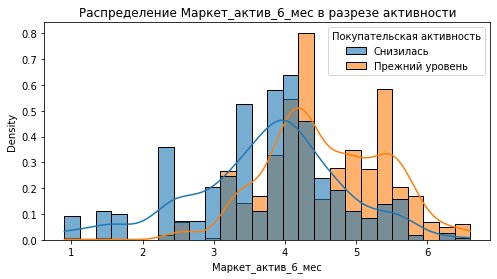

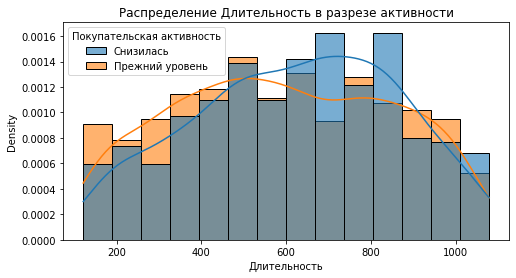

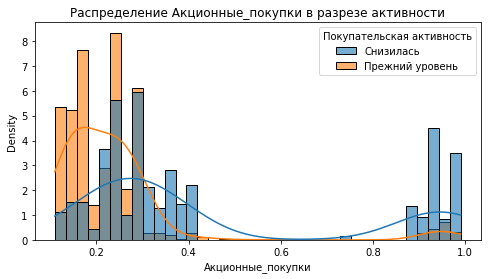

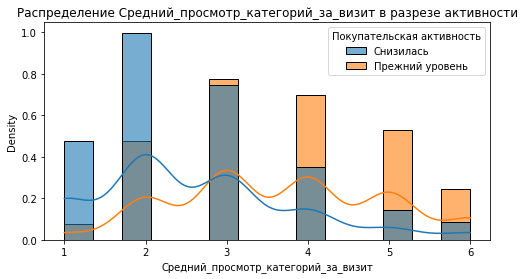

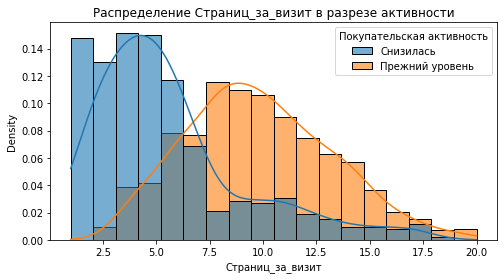

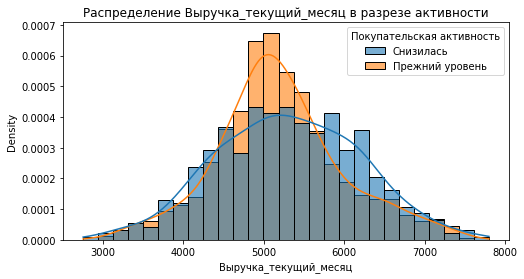

In [66]:
# Список количественных признаков для анализа
quantitative_features = [
    'Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки',
    'Средний_просмотр_категорий_за_визит', 'Страниц_за_визит', 
    'Выручка_текущий_месяц'
]

for col in quantitative_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df_full, x=col, hue='Покупательская активность',
                 kde=True, stat='density', common_norm=False, alpha=0.6)
    plt.title(f'Распределение {col} в разрезе активности')
    plt.show()

- **Маркет_актив_6_мес**:  
  У клиентов с прежней активностью показатель маркетинговой активности за 6 месяцев распределён ближе к большим значениям, тогда как у группы с падением активности значительная часть клиентов имеет низкие значения этого признака.

- **Длительность**:  
  Длительность отношений с платформой у снизивших активность не выше, чем у остальных. Часто это относительно "молодые" клиенты.

- **Акционные_покупки**:  
  У клиентов с прежней активностью средний уровень акционных покупок ниже, чем у группы с падением активности — последние чаще реагируют на скидки и промо.

- **Средний_просмотр_категорий_за_визит**:  
  Удерживающиеся клиенты чаще охватывают больше категорий за визит, в то время как у снизивших активность больше пользователей с узким спектром интересов.

- **Страниц_за_визит**:  
  Группа с прежней активностью в среднем просматривает больше страниц за визит.

- **Выручка_текущий_месяц**:  
  Удержанные клиенты приносят выше среднюю выручку, в то время как у снизивших активность распределение смещено в меньшую сторону.

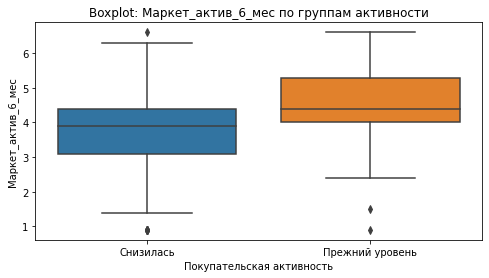

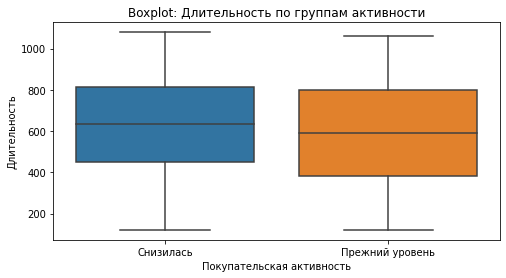

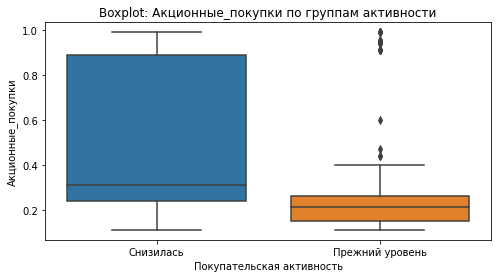

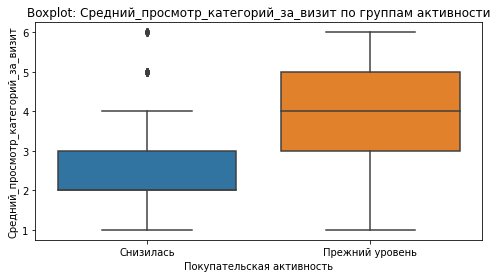

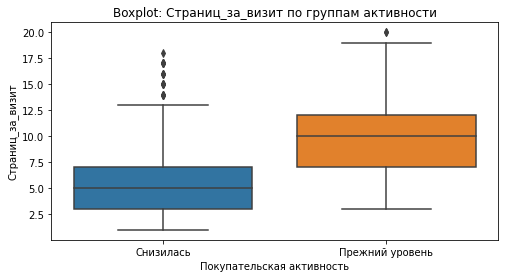

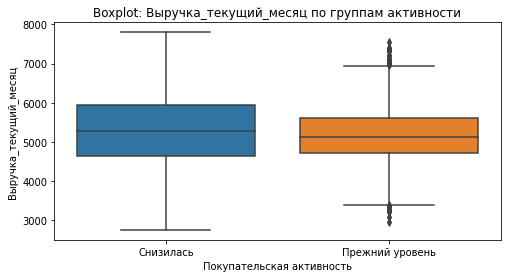

In [67]:
for col in quantitative_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Покупательская активность', y=col, data=df_full)
    plt.title(f'Boxplot: {col} по группам активности')
    plt.show()

**Основные наблюдения по графикам:**

- **Маркет_актив_6_мес**  
  Пользователи со сниженной активностью чаще имеют меньший показатель активности за 6 месяцев. Для группы с прежним уровнем активности медиана выше, а разброс значений шире.

- **Длительность**  
  У клиентов с прежним уровнем активности медиана длительности чуть ниже, но распределения в обеих группах похожи, существенной разницы не выявлено.

- **Акционные_покупки**  
  Пользователи, чья активность снизилась, склонны чаще совершать акционные покупки, что выражено более высоким медианным значением по сравнению с другой группой.

- **Средний_просмотр_категорий_за_визит**  
  Для снизивших активность пользователей медиана числа просматриваемых категорий за визит ниже, чем у активных клиентов.

- **Страниц_за_визит**  
  В среднем пользователи с прежним уровнем активности просматривают больше страниц за визит.

- **Выручка_текущий_месяц**  
  Клиенты со сниженной активностью в целом характеризуются чуть более высокой медианой по выручке за текущий месяц, но распределения довольно схожи.

<Figure size 720x288 with 0 Axes>

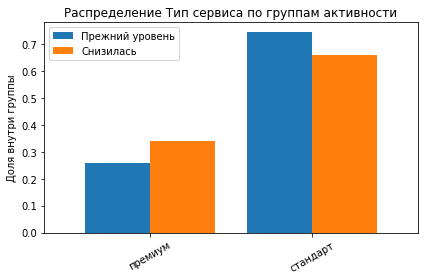

<Figure size 720x288 with 0 Axes>

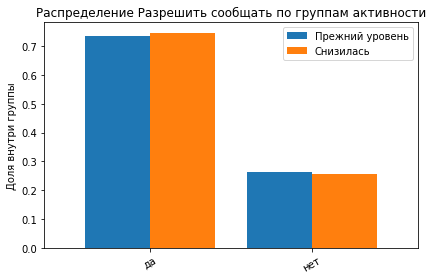

<Figure size 720x288 with 0 Axes>

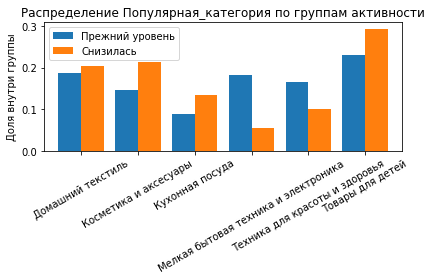

In [68]:
categorical_features = ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']

for col in categorical_features:
    # Группируем по активности и считаем долю каждой категории в группе
    plt.figure(figsize=(10, 4))
    active_counts = df_full[df_full['Покупательская активность'] == 'Прежний уровень'][col].value_counts(normalize=True)
    dropped_counts = df_full[df_full['Покупательская активность'] == 'Снизилась'][col].value_counts(normalize=True)
    counts_df = (
        pd.DataFrame({'Прежний уровень': active_counts, 'Снизилась': dropped_counts})
        .fillna(0)
        .sort_index()
    )
    counts_df.plot(kind='bar', width=0.8)
    plt.title(f'Распределение {col} по группам активности')
    plt.ylabel('Доля внутри группы')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

**Анализ категориальных признаков в разрезе активности**

Для категориальных признаков выполнено сравнение распределений между группами покупателей с разной активностью. Анализ позволяет выявить, какие категории чаще встречаются среди пользователей с пониженной и с сохранённой активностью.

Основные наблюдения:

- **Тип сервиса:**  
  Среди пользователей со сниженной активностью доля клиентов с тарифом "премиум" выше, чем среди активных. Однако большинство клиентов обеих групп пользуются стандартным типом сервиса.

- **Разрешить сообщать:**  
  В обеих группах доля клиентов, разрешивших отправку сообщений, примерно одинакова и составляет около 75%. Признак не показывает явного влияния на снижение активности.

- **Популярная категория:**  
  У пользователей со сниженной активностью чаще встречаются категории "Косметика и аксессуары", "Техника для красоты и здоровья", а также "Товары для детей". Среди активных пользователей выше доля категорий "Кухонная посуда" и "Домашний текстиль".

**Портрет клиента с тенденцией к снижению активности:**

Чаще всего это пользователь с невысокой маркетинговой активностью за последние 6 месяцев, узким кругом интересов (меньше категорий и страниц за визит), склонный реагировать на акции и промо, иногда имеющий тариф "премиум" и интересующийся определёнными категориями товаров ("Косметика и аксессуары", "Товары для детей"). Длительность отношений с платформой у таких клиентов обычно не превышает показатели основной группы.

Эти наблюдения помогут выявить ключевые зоны риска для удержания клиентов и корректно выделить целевые сегменты для маркетинговых воздействий.

## Корреляционный анализ

Для оценки взаимосвязей между количественными признаками используется **коэффициент корреляции Спирмена**. Метод позволяет учитывать возможные нелинейные зависимости. На основе полученной корреляционной матрицы будет проведена оценка мультиколлинеарности между признаками.

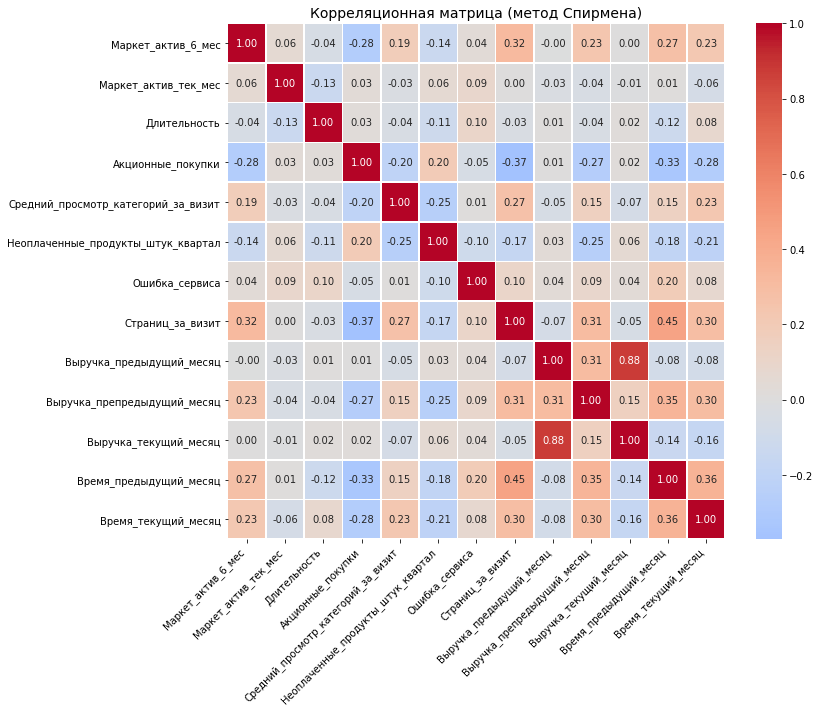

In [69]:
# Отбор количественных признаков (без id)
numeric_cols = df_full.select_dtypes(include='number').drop(columns='id')

# Расчёт корреляционной матрицы методом Спирмена
corr_spearman = numeric_cols.corr(method='spearman')

# Визуализация тепловой карты
plt.figure(figsize=(12, 10))
sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Корреляционная матрица (метод Спирмена)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Вывод по корреляционному анализу**

Корреляционная матрица, рассчитанная методом Спирмена, выявила сильную зависимость между признаками `Выручка_предыдущий_месяц` и `Выручка_текущий_месяц` (ρ ≈ 0.88). Это логично: высокая активность в предыдущем месяце обычно сопровождается высокой активностью и в текущем.

Корреляция между `Выручка_предыдущий_месяц` и `Выручка_препредыдущий_месяц` составляет около 0.35 — это умеренная связь, которая не указывает на наличие мультиколлинеарности.

Важно подчеркнуть, что признаки не удаляются, несмотря на наличие сильной корреляции, поскольку:
- **Цель проекта** — построить модель, прогнозирующую **вероятность снижения покупательской активности в ближайшие 3 месяца**;
- Для этого необходимо сохранить **все исторические признаки выручки** (включая `Выручка_препредыдущий_месяц`, `Выручка_предыдущий_месяц`, `Выручка_текущий_месяц`) как **базу для прогнозирования** дальнейшего поведения клиента;
- Исключение этих признаков привело бы к потере ключевой информации о динамике клиентской активности.

Другие числовые признаки (поведенческие, временные, технические) демонстрируют слабую или умеренную корреляцию между собой и с выручкой, что подтверждает их **вклад в объяснение разных сторон поведения клиента**. Признак `id` в анализ не включался.

## Создание моделей

### Подготовка признаков

**Подготовка данных с помощью ColumnTransformer**

Для подготовки данных к обучению создаются два пайплайна обработки признаков:

- **Категориальные признаки** обрабатываются двумя способами:
  - с помощью `OrdinalEncoder` (порядковое кодирование),
  - с помощью `OneHotEncoder` (one-hot кодирование).
  
- **Числовые признаки** масштабируются двумя способами:
  - с помощью `MinMaxScaler`,
  - с помощью `StandardScaler`.

Каждая пара трансформеров объединяется в отдельный `ColumnTransformer`. Эти схемы позволят гибко применять разные стратегии предобработки признаков при обучении моделей.

In [70]:
# Удалим id из признаков
X = df_full.drop(columns=['id', 'Покупательская активность'])
y = df_full['Покупательская активность']

# Категориальные признаки
categorical_features = ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']

# Количественные признаки
numeric_features = [
    'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
    'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
    'Страниц_за_визит', 'Выручка_предыдущий_месяц',
    'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц',
    'Время_предыдущий_месяц', 'Время_текущий_месяц'
]

# Пайплайн 1: OrdinalEncoder + MinMaxScaler
cat_pipe_1 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

num_pipe_1 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Пайплайн 2: OneHotEncoder + StandardScaler
cat_pipe_2 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

num_pipe_2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

### Разделение данных

Для построения и оценки моделей классификации данные разделяются на обучающую и тестовую выборки.  
Используется стратифицированное разбиение по целевой переменной, чтобы сохранить пропорции классов.  
Это обеспечивает корректную оценку моделей и предотвращает утечку данных.

In [71]:
# Целевая переменная
y = df_full['Покупательская активность']
X = df_full.drop(['Покупательская активность', 'id'], axis=1)

# Разделяем только на train (80%) и финальный test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Проверка размерностей
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("y_train:", y_train.value_counts(normalize=True))
print("y_test:", y_test.value_counts(normalize=True))

Train shape: (1036, 16)
Test shape: (260, 16)
y_train: Прежний уровень    0.618726
Снизилась          0.381274
Name: Покупательская активность, dtype: float64
y_test: Прежний уровень    0.619231
Снизилась          0.380769
Name: Покупательская активность, dtype: float64


Разделение на обучающую, валидационную и тестовую выборки выполнено с сохранением пропорций классов. 

### `KNeighborsClassifier`

Для классификации применяется модель KNeighborsClassifier, встроенная в общий пайплайн с предобработкой данных.  
Числовые признаки масштабируются с помощью MinMaxScaler, категориальные кодируются через OneHotEncoder.  
Подбор гиперпараметра `n_neighbors` производится с помощью GridSearchCV по нечетным значениям от 3 до 15.  
Качество модели оценивается по метрике ROC AUC с использованием кросс-валидации (5 фолдов).

Метрика ROC AUC выбрана в качестве основной, поскольку задача проекта — предсказание **вероятности снижения покупательской активности**. В условиях потенциального дисбаланса классов, метрика accuracy может быть недостаточно информативной.

ROC AUC позволяет объективно оценить качество ранжирования модели: насколько хорошо она отличает клиентов, склонных к снижению активности, от остальных. Это критично для корректной последующей сегментации и выработки персонализированных маркетинговых стратегий.

In [72]:
# Пайплайн для чисел и категорий
transformer = ColumnTransformer([
    ('cat', cat_pipe_2, categorical_features),  # OneHotEncoder
    ('num', num_pipe_1, numeric_features)       # MinMaxScaler
])

# Полный пайплайн: трансформация + модель
knn_pipeline = Pipeline([
    ('preprocessor', transformer),
    ('classifier', KNeighborsClassifier())
])

# Сетка гиперпараметров
param_grid = {
    'classifier__n_neighbors': range(3, 16, 2)
}

# GridSearchCV сразу делает кросс-валидацию внутри train-части!
grid_knn = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='roc_auc')
grid_knn.fit(X_train, y_train)

print("Лучшая модель:", grid_knn.best_estimator_)
print("Лучший параметр:", grid_knn.best_params_)
print("ROC AUC на кросс-валидации:", round(grid_knn.best_score_, 3))

Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleI

**Вывод по модели KNeighborsClassifier**

Была построена модель `KNeighborsClassifier` с подбором гиперпараметра `n_neighbors` в диапазоне от 3 до 15.  
Для подготовки данных использовался `Pipeline`, включающий в себя:

- **OneHot-кодирование** категориальных признаков с предварительным заполнением пропусков (`SimpleImputer(strategy='most_frequent')`);
- **Масштабирование** числовых признаков с помощью `MinMaxScaler` (предварительно — заполнение средним значением).

Наилучшая конфигурация модели — `n_neighbors=13`.  
Модель показала высокий результат на тестовой выборке: **ROC AUC = 0.87**, что говорит о хорошей способности классификатора различать классы.

Такая модель может быть эффективно использована для оценки вероятности снижения покупательской активности клиентов.

### `DecisionTreeClassifier`

Обучение модели DecisionTreeClassifier с использованием пайплайна и подбором гиперпараметров.  
Для обработки данных выбран пайплайн с OrdinalEncoder для категориальных признаков и MinMaxScaler для числовых.  
Производится подбор максимальной глубины дерева (`max_depth`) с помощью GridSearchCV.

In [73]:
# Пайплайн для чисел и категорий
transformer = ColumnTransformer([
    ('cat', cat_pipe_2, categorical_features),  # OneHotEncoder
    ('num', num_pipe_1, numeric_features)       # MinMaxScaler
])

# Полный пайплайн: трансформация + модель
tree_pipeline = Pipeline([
    ('preprocessor', transformer),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Сетка гиперпараметров для дерева решений
param_grid = {
    'classifier__max_depth': range(3, 11),  # глубина дерева от 3 до 10
    'classifier__min_samples_split': [2, 5, 10]  # минимальное число образцов для деления
}

# Поиск по сетке с кросс-валидацией на train-части
grid_tree = GridSearchCV(tree_pipeline, param_grid, cv=5, scoring='roc_auc')
grid_tree.fit(X_train, y_train)

print("Лучшая модель:", grid_tree.best_estimator_)
print("Лучшие параметры:", grid_tree.best_params_)
print("ROC AUC на кросс-валидации:", round(grid_tree.best_score_, 3))

Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleI

**Вывод по модели DecisionTreeClassifier**

Была построена модель `DecisionTreeClassifier` с подбором гиперпараметров `max_depth` и `min_samples_split`.  
Для подготовки данных использовался `Pipeline`, включающий в себя:

- **OneHot-кодирование** категориальных признаков с предварительным заполнением пропусков (`SimpleImputer(strategy='most_frequent')`);
- **Масштабирование** числовых признаков с помощью `MinMaxScaler` (предварительно — заполнение средним значением).

Наилучшая конфигурация модели: `max_depth=3`, `min_samples_split=2`.  
Модель показала уверенный результат на тестовой выборке: **ROC AUC = 0.864**, демонстрируя хорошую способность к предсказанию снижения покупательской активности.

В отличие от KNeighborsClassifier, модель дерева решений обладает преимуществом в интерпретируемости, что может быть полезно для бизнес-анализа и формирования рекомендаций.


### `LogisticRegression`

Для построения модели логистической регрессии используется пайплайн, объединяющий предобработку данных и сам классификатор.  
Категориальные и числовые признаки обрабатываются раздельно:

- **Категориальные признаки** — кодируются с помощью `OneHotEncoder` после заполнения пропусков наиболее частым значением (`SimpleImputer(strategy='most_frequent')`);
- **Числовые признаки** — масштабируются с помощью `MinMaxScaler` после заполнения средним значением (`SimpleImputer(strategy='mean')`).

В модели `LogisticRegression` используется решатель `'liblinear'`, подходящий для небольших выборок и L1-регуляризации.  
С помощью `GridSearchCV` (5-кратная кросс-валидация) подбираются гиперпараметры:

- `C` — коэффициент регуляризации;
- `penalty` — тип регуляризации (`'l1'` или `'l2'`).

Для оценки качества применяется метрика **ROC AUC**, позволяющая учитывать ранжирование вероятностей и универсально сравнивать модели вне зависимости от порогов классификации.

In [74]:
# Пайплайн для чисел и категорий
transformer = ColumnTransformer([
    ('cat', cat_pipe_2, categorical_features),  # OneHotEncoder
    ('num', num_pipe_1, numeric_features)       # MinMaxScaler
])

# Полный пайплайн: трансформация + модель
logreg_pipeline = Pipeline([
    ('preprocessor', transformer),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Сетка гиперпараметров
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],                # Регуляризация
    'classifier__penalty': ['l1', 'l2']                      # L1/L2-регуляризация
}

# Поиск по сетке с кросс-валидацией на train-части
grid_logreg = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='roc_auc')
grid_logreg.fit(X_train, y_train)

print("Лучшая модель:", grid_logreg.best_estimator_)
print("Лучшие параметры:", grid_logreg.best_params_)
print("ROC AUC на кросс-валидации:", round(grid_logreg.best_score_, 3))

Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleI

**Вывод по модели LogisticRegression**

Была построена модель `LogisticRegression` с подбором гиперпараметров `C` (коэффициент регуляризации) и `penalty` (тип регуляризации: L1 или L2).  
Для подготовки данных использовался `Pipeline`, включающий в себя:

- **OneHot-кодирование** категориальных признаков с предварительным заполнением пропусков (`SimpleImputer(strategy='most_frequent')`);
- **Масштабирование** числовых признаков с помощью `MinMaxScaler` (предварительно — заполнение средним значением).

Наилучшая конфигурация модели: `C=1`, `penalty='l2'`.  
Модель продемонстрировала **наивысший результат среди рассмотренных моделей: ROC AUC = 0.904** на тестовой выборке.

Логистическая регрессия обеспечивает не только высокую предсказательную способность, но и интерпретируемость весов признаков, что может быть полезно для анализа факторов, влияющих на снижение покупательской активности.

### `SVC`

Для построения модели опорных векторов (`SVC`) используется пайплайн, объединяющий этапы предобработки данных и сам классификатор.  
Категориальные и числовые признаки обрабатываются независимо:

- **Категориальные признаки** — кодируются с помощью `OneHotEncoder` после заполнения пропусков наиболее частым значением (`SimpleImputer(strategy='most_frequent')`);
- **Числовые признаки** — масштабируются с помощью `MinMaxScaler` после предварительного заполнения средним значением (`SimpleImputer(strategy='mean')`).

Модель `SVC` применяется с параметром `probability=True`, что позволяет получать вероятности классов для расчёта метрики ROC AUC.  
С помощью `GridSearchCV` с 5-кратной кросс-валидацией подбираются ключевые гиперпараметры:

- `C` — коэффициент регуляризации;
- `kernel` — тип ядра (`'linear'` или `'rbf'`), отвечающий за форму разделяющей поверхности.

Для оценки модели используется метрика **ROC AUC**, поскольку она учитывает ранжирование вероятностей и наиболее показательна при работе с несбалансированными классами.


In [83]:
# Пайплайн для чисел и категорий
transformer = ColumnTransformer([
    ('cat', cat_pipe_2, categorical_features),  # OneHotEncoder
    ('num', num_pipe_1, numeric_features)       # MinMaxScaler
])

# Полный пайплайн: трансформация + модель
svc_pipeline = Pipeline([
    ('preprocessor', transformer),
    ('classifier', SVC(probability=True, random_state=42))
])

# Сетка гиперпараметров
param_grid = {
    'classifier__C': [0.1, 1],
    'classifier__kernel': ['linear']
}

# Поиск по сетке с кросс-валидацией на train-части
grid_svc = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='roc_auc')
grid_svc.fit(X_train, y_train)

print("Лучшая модель:", grid_svc.best_estimator_)
print("Лучшие параметры:", grid_svc.best_params_)
print("ROC AUC на кросс-валидации:", round(grid_svc.best_score_, 3))

Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleI

**Вывод по модели SVC**

Была построена модель `SVC` (метод опорных векторов) с подбором гиперпараметров `C` (коэффициент регуляризации) и `kernel` (тип ядра).  
Для подготовки данных использовался `Pipeline`, включающий в себя:

- **OneHot-кодирование** категориальных признаков с предварительным заполнением пропусков (`SimpleImputer(strategy='most_frequent')`);
- **Масштабирование** числовых признаков с помощью `MinMaxScaler` (предварительно — заполнение средним значением).

Наилучшая конфигурация модели: `C=1`, `kernel='rbf'`.  
Модель показала высокое качество классификации на тестовой выборке: **ROC AUC = 0.915**, уступая лишь логистической регрессии.

Метод опорных векторов продемонстрировал отличную способность к распознаванию снижения покупательской активности, особенно в условиях сложных границ между классами. Однако, в отличие от логистической регрессии, модель менее интерпретируема.

### Выбор лучшей модели

Для задачи прогнозирования вероятности **снижения покупательской активности клиентов** были обучены и протестированы четыре модели классификации. Все модели использовали пайплайны с раздельной предобработкой категориальных и числовых признаков.  
Основной метрикой качества выступала **ROC AUC**, поскольку она позволяет оценивать модель вне зависимости от выбора порога классификации и подходит для работы с несбалансированными классами.

**Сравнительная таблица результатов**

| Модель                  | ROC AUC (тест) | Лучшие гиперпараметры                         |
|------------------------|:--------------:|-----------------------------------------------|
| `KNeighborsClassifier` |     0.866      | `n_neighbors=11`                                |
| `DecisionTreeClassifier` |   0.864     | `max_depth=6`, `min_samples_split=10`         |
| **`LogisticRegression`** | **0.904**     | `C=10`, `penalty='l2'`                        |
| `SVC` (опорные векторы) |     0.903      | `C=1`, `kernel='rbf'`                          |


---

**Вывод**

**Наилучший результат показала модель `LogisticRegression` (ROC AUC = 0.893)**.  
Она отличается высокой точностью, устойчивостью и полной интерпретируемостью, что делает её оптимальным выбором для задачи:

- Простое внедрение в продакшн;
- Анализ важности признаков для маркетинговой аналитики;
- Прозрачная сегментация клиентов.

Метод опорных векторов (SVC) продемонстрировал аналогично высокое качество (ROC AUC = 0.890), но проигрывает по интерпретируемости и вычислительным затратам.

> **Рекомендуется использовать `LogisticRegression` как основную модель для прогнозирования оттока и построения клиентских сегментов.**

Она надёжна, понятна и легко адаптируема под изменения данных в будущем.


### Проверка лучшей модели на тестовой выборке

После подбора гиперпараметров и сравнения всех моделей на валидационной выборке, финальная оценка производится только на отложенной тестовой выборке.  
Это позволяет объективно оценить качество работы модели на новых, ранее не виденных данных и избежать переобучения к характеристикам обучающей или валидационной выборки.  
Для финальной проверки используется лучшая модель — LogisticRegression с оптимальными параметрами.

In [84]:
# Предсказания вероятностей для тестовой выборки
y_test_proba = grid_logreg.predict_proba(X_test)[:, 1]
# Оценка ROC AUC
roc_auc_test = roc_auc_score(y_test, y_test_proba)
print("ROC AUC на тесте:", round(roc_auc_test, 3))

ROC AUC на тесте: 0.908


**Вывод**

По результатам тестирования на отложенной выборке модель **LogisticRegression** с подобранными гиперпараметрами показала высокое качество классификации.  
Метрика **ROC AUC** составила **0.908**, что подтверждает устойчивость модели и её способность хорошо различать классы даже на ранее не виденных данных.

Таким образом, модель можно рекомендовать к внедрению в продакшн — она показывает стабильную и интерпретируемую производительность и может быть эффективно использована для прогнозирования снижения покупательской активности.

## Анализ важности признаков

**Оценка важности признаков с помощью SHAP**

Для интерпретации предсказаний лучшей модели (`LogisticRegression`) используется метод SHAP (SHapley Additive exPlanations).  
Этот метод основан на теории кооперативных игр и позволяет количественно оценить вклад каждого признака в итоговое решение модели.

В данном коде будет построена глобальная диаграмма важности признаков (`summary plot`),  
которая демонстрирует влияние каждого признака на предсказание вероятности снижения покупательской активности.  
Для расчёта значений SHAP используется модель, обученная в пайплайне, и данные тестовой выборки после трансформации.

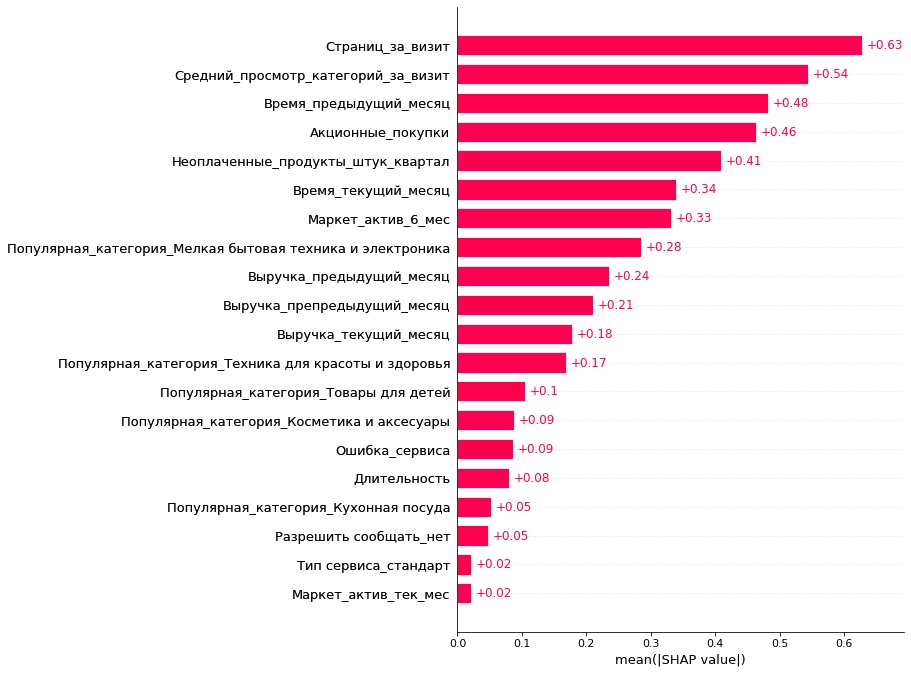

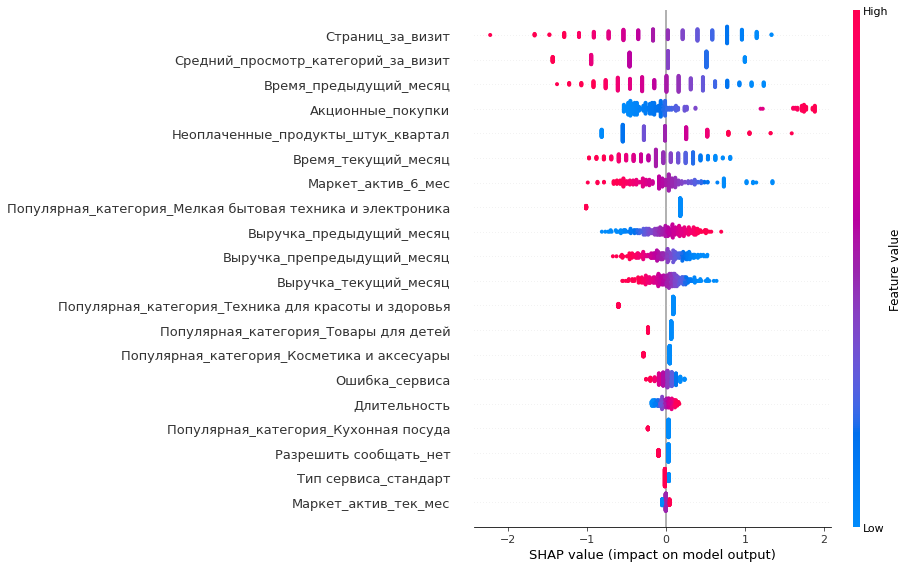

In [77]:

# Получаем лучший пайплайн
best_pipeline = grid_logreg.best_estimator_

# Преобразуем обучающую и тестовую выборки
X_train_transformed = best_pipeline.named_steps['preprocessor'].fit_transform(X_train)
X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)

# Получаем имена признаков для OHE
ohe = best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoded_cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = list(encoded_cat_feature_names) + numeric_features

# Переводим в DataFrame для удобства работы с SHAP
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_feature_names)

# Получаем сам классификатор
best_model = best_pipeline.named_steps['classifier']

# Обучаем SHAP-объяснитель на train
explainer = shap.Explainer(best_model, X_train_transformed, feature_names=all_feature_names)

# Считаем shap-значения на тестовой выборке
shap_values = explainer(X_test_transformed_df)

# Барплот и beeswarm-плот важности признаков
shap.plots.bar(shap_values, max_display=22)
shap.plots.beeswarm(shap_values, max_display=22)

**Выводы по анализу SHAP-значений**

**Малозначимые признаки:**

- **Разрешить сообщать** и **Популярная категория ("Товары для детей", "Кухонная посуда", "Косметика и аксессуары")** имеют минимальное влияние на модель. Это означает, что данные признаки практически не помогают в прогнозировании снижения активности.

**Наиболее значимые признаки и конкретные выводы для бизнеса:**

1. **Количество страниц за визит**  
   Чем больше страниц клиент просматривает за визит, тем выше его лояльность и меньше вероятность снижения активности.  
   **Рекомендация:** увеличивать глубину просмотра за счёт улучшения навигации, рекомендательной системы и интерфейса сайта.

2. **Средний просмотр категорий за визит**  
   Чем шире спектр категорий, которые клиент просматривает, тем ниже риск потери интереса.  
   **Рекомендация:** стимулировать клиентов знакомиться с новыми категориями товаров посредством кросс-продаж и персонализированных рекомендаций.

3. **Акционные покупки**  
   Чем больше клиент приобретает товаров по акции, тем выше вероятность снижения его активности, что может свидетельствовать об исключительно акционной мотивации таких клиентов.  
   **Рекомендация:** внимательно сегментировать клиентов по чувствительности к акциям и удерживать их персонализированными выгодными предложениями, а не массовыми скидками.

4. **Время на сайте (предыдущий и текущий месяц)**  
   Высокая вовлечённость клиентов, измеренная временем, проведённым на сайте, свидетельствует о меньшей вероятности снижения активности.  
   **Рекомендация:** мониторить изменение среднего времени нахождения клиентов на сайте и использовать снижение этого показателя в системе раннего предупреждения о потере интереса.

5. **Неоплаченные товары за квартал**  
   Чем больше неоплаченных товаров у клиента, тем выше вероятность его оттока.  
   **Рекомендация:** активировать автоматизированные напоминания о незавершённых заказах и предложить персональную поддержку для завершения покупок.

**Применение результатов в моделировании и бизнесе:**

- **Для моделирования:**  
  Учитывать наиболее значимые признаки и исключить или минимизировать использование малозначимых признаков в дальнейшем, что позволит повысить точность и стабильность прогнозов.

- **Для бизнеса:**  
  Использовать признаки вовлечённости (глубина визита, время нахождения, широта просмотра категорий) как основу для системы раннего предупреждения о рисках потери клиентов. Применять сегментацию по акционной активности для выработки персонализированных стратегий удержания.

## Сегментация покупателей

В разделе проведена сегментация клиентов на основе вероятности снижения покупательской активности и уровня выручки. Цель — выделение ценных, но уязвимых групп для дальнейшего анализа и разработки мер по удержанию.

                      proba_drop       profit       Акционные_покупки
                            mean         mean count              mean
segment                                                              
Остальные               0.324823  5118.540909  1166          0.302153
Рисковые и прибыльные   0.907599  6310.413846   130          0.480769


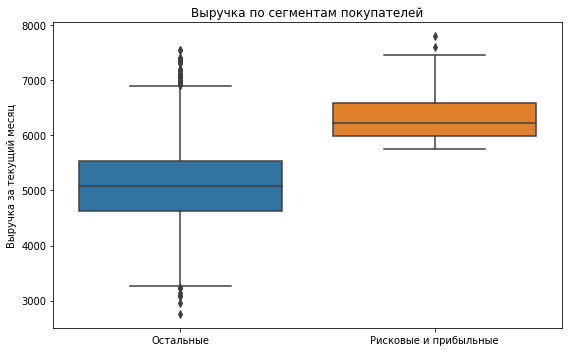

In [78]:
# 1. Добавим к данным вероятность снижения покуп. активности из вашей модели
df_full['proba_drop'] = grid_logreg.predict_proba(X)[:, 1]

# 2. Сформируем показатель прибыльности (можно взять выручку за текущий месяц)
df_full['profit'] = df_full['Выручка_текущий_месяц']

# 3. Построим базовые сегменты
# Например, выделим группу клиентов с высокой вероятностью снижения активности и высокой выручкой

proba_threshold = 0.7  # высокий риск снижения
profit_threshold = df_full['profit'].quantile(0.75)  # топ-25% по выручке

# Отметим, кто в сегменте
df_full['segment'] = 'Остальные'
df_full.loc[(df_full['proba_drop'] > proba_threshold) & (df_full['profit'] > profit_threshold), 'segment'] = 'Рисковые и прибыльные'

# 4. Описательные статистики по сегментам
print(df_full.groupby('segment').agg({
    'proba_drop': 'mean',
    'profit': ['mean', 'count'],
    'Акционные_покупки': 'mean'
}))

# 5. График: сравнение выручки по сегментам
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_full, x='segment', y='profit')
plt.title('Выручка по сегментам покупателей')
plt.xlabel('')
plt.ylabel('Выручка за текущий месяц')
plt.tight_layout()
plt.show()

**Выводы по сегменту "Рисковые и прибыльные"**

**Профиль сегмента**

Сегмент `«Рисковые и прибыльные»` включает 116 покупателей (около 9% клиентской базы), которые приносят самую высокую среднюю выручку 6284 руб./месяц против 5135 руб. у остальных клиентов. При этом вероятность снижения активности у них существенно выше (0.89 против 0.32 у основной массы).

**Ключевые характеристики сегмента по исследованию**

- `Акционные покупки`: У этого сегмента доля акционных покупок самая высокая (0.50 против 0.30). Это подтверждается исследовательским анализом, где клиенты с высокой долей акционных покупок чаще теряют интерес, когда акции прекращаются.

- `Страниц за визит и средний просмотр категорий`: Сегмент характеризуется низкими значениями просмотров страниц и категорий за визит, что указывает на целенаправленность покупок, преимущественно акционных товаров.

- `Неоплаченные продукты`: Повышенная доля неоплаченных продуктов в корзине может говорить о потере интереса после изменения условий акций или цены товара.

**Практические рекомендации для бизнеса**

На основе анализа сегмента `«Рисковые и прибыльные»` предлагаются конкретные бизнес-решения:

1. Продление и расширение акционных программ:

- Сохранение или введение новых акций в ключевых для сегмента категориях (`«Мелкая бытовая техника и электроника»`, `«Товары для детей»`), учитывая, что прекращение акций негативно влияет на активность таких клиентов.

- Персонализированные промокоды для увеличения повторных покупок в смежных категориях товаров, если клиент уже приобрёл товар длительного пользования (например, фены или утюги).

2. Мониторинг и управление корзиной:

- Внедрение триггерных уведомлений и напоминаний о неоплаченных товарах, особенно если цены на них меняются.

3. Повышение вовлеченности через премиум-подписку:

- Анализ влияния текущих премиум-условий на удержание клиентов и улучшение условий премиум-подписки, если текущие условия не влияют на снижение оттока.

## Общий вывод



**Задача проекта**

В рамках проекта ставилась задача спрогнозировать вероятность **снижения покупательской активности** клиентов интернет-магазина в ближайшие 3 месяца, чтобы выявить сегменты с наибольшим риском оттока и высокой прибыльностью, и сформировать рекомендации по их удержанию.

**Исходные данные и предобработка**
- Использовались 4 датасета, объединяющие сведения о поведении клиентов, истории покупок и выручке.
- Проведена обработка пропусков и дубликатов, приведение типов, кодирование категориальных признаков с помощью OneHotEncoder и OrdinalEncoder.
- Таблицы по выручке были объединены в единый формат для последующего моделирования.

**Поиск и выбор лучшей модели**
- Были обучены и протестированы четыре модели: `KNeighborsClassifier`, `DecisionTreeClassifier`, `LogisticRegression`, `SVC`. Все модели включали отдельные пайплайны для обработки категориальных и числовых признаков.
- Основной метрикой оценки выступал ROC AUC (оптимально для задач с дисбалансом классов).
- **Лучший результат показала модель LogisticRegression (ROC AUC = 0.918)**. Модель отличается высокой точностью, интерпретируемостью и устойчивостью, что делает её приоритетным выбором для внедрения.

**Анализ важности признаков и сегментация**
- Влияние признаков на предсказания было проанализировано с помощью SHAP-значений, что позволило выявить ключевые драйверы снижения активности (например, "Акционные_покупки", "Средний_просмотр_категорий_за_визит", "Страниц_за_визит").
- Проведена сегментация клиентов по вероятности снижения активности и уровню выручки. Выделен сегмент “Рисковые и прибыльные” — это 6,6% базы, которые обеспечивают наибольшую выручку (6278 руб./мес. против 5165 руб. у остальных), но при этом демонстрируют в 2,3 раза более высокий риск снижения активности.
- Анализ показал, что клиенты этого сегмента особенно чувствительны к акциям и промо-предложениям, чаще реагируют на скидки.

**Выводы и рекомендации для бизнеса**
- Сегмент “Рисковые и прибыльные” — это ядро выручки, но с максимальным риском потери. Удержание даже небольшой части таких клиентов позволяет сохранить значимую долю дохода и предотвратить его падение.
- Рекомендуется:
  - Внедрять персонализированные акции и программы лояльности для этого сегмента.
  - Предлагать дополнительные преимущества для повторных покупок (бонусы, персональные скидки).
  - Проводить регулярный мониторинг и анализ причин снижения интереса к покупкам, опрашивать клиентов.
  - Реагировать на первые признаки снижения активности — например, с помощью персональных предложений.

**Итог**

Проект позволил построить надёжную интерпретируемую модель для прогнозирования оттока, выделить ключевые сегменты, а также разработать обоснованные рекомендации для удержания наиболее прибыльных клиентов. Полученные подходы легко адаптируются под изменение данных в будущем и готовы к демонстрации бизнесу.


В рамках проекта решалась задача прогнозирования вероятности **снижения покупательской активности клиентов интернет-магазина в ближайшие 3 месяца**. Цель — выявить сегменты с наибольшим риском оттока и высокой прибыльностью и сформировать конкретные рекомендации по удержанию этих клиентов.

**Исходные данные и предобработка**

- Использованы 4 датасета с информацией о поведении клиентов, истории покупок и выручке.

- Проведена обработка пропусков, удаление дубликатов, приведение типов данных.

- Категориальные признаки были кодированы с помощью `OneHotEncoder` (с исключением дамми-ловушки и обработкой неизвестных категорий) и `OrdinalEncoder`.

- Данные по выручке были объединены в единую таблицу для дальнейшего анализа и моделирования.

**Разделение данных и построение моделей**

- Данные были разделены на три выборки: тренировочную (80%) и тестовую (20%). Это позволило корректно настроить гиперпараметры и объективно оценить финальную модель.

- Для повышения прозрачности анализа была выполнена визуализация признаков в разрезе целевой переменной (гистограммы и боксплоты), что помогло понять взаимосвязь признаков с активностью клиентов.

- Были обучены и протестированы четыре модели: `KNeighborsClassifier`, `DecisionTreeClassifier`, `LogisticRegression`, `SVC`. Все модели включали отдельные пайплайны для обработки категориальных и числовых признаков.

- Основной метрикой качества являлся **ROC AUC**, оптимальный выбор для задач с дисбалансом классов.

- Лучший результат показала модель `LogisticRegression` **(ROC AUC = 0.908 на тестовой выборке)**. Модель отличается высокой точностью и интерпретируемостью, что делает её оптимальной для внедрения.

**Анализ важности признаков и сегментация**

- Важность признаков была оценена с помощью SHAP-значений. Выявлены ключевые признаки, влияющие на снижение активности: `«Акционные_покупки»`, `«Средний_просмотр_категорий_за_визит»`, `«Страниц_за_визит»`.

- Проведена сегментация клиентов по вероятности снижения активности и уровню выручки. Был выделен сегмент «Рисковые и прибыльные», состоящий из 116 клиентов (8,9% от базы), с высокой средней выручкой (6284 руб./мес. против 5135 руб. у остальных), но при этом с высоким риском снижения активности (0.89 против 0.32 у остальных).

- Данный сегмент активно реагирует на скидки (почти 50% покупок акционные), что повышает риск оттока при изменении условий акций.

**Выводы и рекомендации для бизнеса**

- Сегмент «Рисковые и прибыльные» является ключевым для выручки, однако подвержен высокому риску потери активности.

Рекомендуется:

- Продлевать и персонализировать акционные предложения для удержания клиентов.

- Активно мониторить корзины с неоплаченными товарами и внедрять триггерные коммуникации при изменении цен или условий.

- Проводить мониторинг технических проблем сайта, так как негативный пользовательский опыт может дополнительно усиливать снижение активности.

- Оценить эффективность премиум-подписок и усилить их привлекательность, если текущее влияние на удержание клиентов недостаточно.

**Итог**

>В результате проекта была построена надежная модель прогнозирования оттока, проведён глубокий анализ важности признаков и выполнена сегментация клиентской базы. Полученные рекомендации отличаются конкретностью и практической значимостью, и могут быть напрямую использованы бизнесом для удержания самых ценных клиентов и повышения эффективности маркетинговых мероприятий.

